Introduction-Business Problem
=================================
- **Business Problem:**
Starting an business has been always risky, because after investing money, time and effort into opening the business, due to many factors, it may not succeed, that is why it is essential to study the market first, and the first thing to decide on is the type of industry you will enter.
And the success of a certain industry is usually related to the existence of another, so we will use current opening businesses in Alexandria, Egypt
to investigate what business work with what and in which neighborhood, and this process can be implemented with any city.
- **Target Audience:** This project can be implemented in a business consultant firm, that give clients - based on their prefrences, budgets, or desires - an idea on what might work and what might not.

Data
--
We will need to gather the locations of the neighborhoods in Alexandria form wikipedia and user those locations with foursquare API to gather venue inforomation in each neighborhood.</br>
- **BeatifulSoup:** is used to scrape the locations of the neighborhoods in Alexandria.
- **Foursquare API:** via the search endpoint in the venues group, this source allows to retrieve information such as:

    - getting a list of venues/business in a certain location</br><code>https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={}&v={}</code>
- **Nominatim:** Nominatim is a search engine for <a href="openstreetmap.org">openstreetmap.org</a> data available for use in Python within the geopy.geocoders library; in the context of this solution, Nominatim is used to perform geocoding of popular places' address



In [0]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [0]:
alexandria_neighborhoods = ['Amreya', 'Anfoushi', 'Asafra', 'Azarita', 'Bahary', 'Bakos', 'Baucalis', 'Bolkly', 'Camp Chezar', 
                            'Cleopatra', 'Dekhela', 'Downtown', 'Atareen', 'Gomrok', 'Ibrahimiya', 'Labban', 'Maamora Beach',
                            'Maamora', 'Mandara', 'Mansheya', 'Max', 'Qabary', 'Saraya', 'Soyof', 'Fleming', 'Gianaclis', 'Glim', 
                            'Hadara', 'Kafr Abdu', 'Karmoz', 'Kom El Deka', 'Louran', 'Mahatet El Raml', 'Miami', 'Moharam Bek',
                            'Montaza', 'Roshdy', 'Saba Pasha', 'Safar', 'San Stefano', 'Shatby', 'Shods', 'Sidi Bishr', 'Sidi Gaber',
                            'Smouha', 'Sporting', 'Stanley', 'Tharwat', 'Victoria', 'Wardeyan', 'Zezenia']

In [0]:
def get_titles_hrefs_of_neighborhoods(url):
  """
  Get two lists one that contains the neighborhoods' names, and the other has the /wiki/<neighborhood> location
  in the https://en.wikipeida.org/....
  INPUT:
  ------
    - url: the url that contains the list of neighborhoods
  OUTPUT:
  -------
    - titles: a list that contains the titles of the neighborhood
    - href: a list that contains the locations of the neighborhood wikipeida page
  """
  titles = []
  hrefs = []
  
  wiki_page = requests.get(url).text
  soup = BeautifulSoup(wiki_page, 'html.parser')
  for mw_pages in soup.find_all(id='mw-pages'):
    for my_category_group in mw_pages.find_all(attrs={'class': 'mw-category-group'}):
      for li in my_category_group.find_all('li'):
        titles.append(li.find_all('a')[0]['title'])
        hrefs.append(li.find_all('a')[0]['href'])
  return titles, hrefs

In [46]:
# Get the titles and hrefs lists
url = 'https://en.wikipedia.org/wiki/Category:Neighbourhoods_of_Alexandria'
titles, hrefs = get_titles_hrefs_of_neighborhoods(url)

neighborhoods_locations = []

for href in hrefs:
  neighborhood_url = 'https://en.wikipedia.org/' + href
  try:
    wiki_page = requests.get(neighborhood_url).text
    soup = BeautifulSoup(wiki_page, 'html.parser')
    loc_string = str(soup.find_all(attrs={'class':'geo-dec'})[0].string)
    loc_string = loc_string.replace('°N ', ',')
    loc_string = loc_string.replace('°E', '')
    neighborhoods_locations.append(loc_string)
  except:
    print(href + " did not have a location, probabily it is not a neighborhood.")

/wiki/Template:Neighborhoods_in_Alexandria did not have a location, probabily it is not a neighborhood.
/wiki/Anfoushi did not have a location, probabily it is not a neighborhood.
/wiki/Baucalis did not have a location, probabily it is not a neighborhood.


See the number of neighborhoods, and the number of locations

In [47]:
print(len(titles))
print(len(neighborhoods_locations))

53
50


We see that there are non-valid neighborhood names, or neighborhoods that don't have a location in their wikipedia pages, so we drop them.

In [48]:
remove_neighborhoods = ['Template:Neighborhoods in Alexandria', 'Anfoushi', 'Baucalis']

for neighborhood in remove_neighborhoods:
  del titles[titles.index(neighborhood)]

print(len(titles))
print(len(neighborhoods_locations))

50
50


Let's form the neighborhoods dataframe

In [56]:
data = {
    'Neighborhood': titles,
    'Latitude': [loc.split(',')[0] for loc in neighborhoods_locations],
    'Longitude': [loc.split(',')[1] for loc in neighborhoods_locations]
}
alex_neighborhoods_df = pd.DataFrame(data)
alex_neighborhoods_df.head()

,Neighborhood,Latitude,Longitude
0,Amreya,31.104538,29.766226
1,Asafra,31.20502,29.906402
2,Azarita,31.206121,29.914813
3,Bahary,31.194999,29.897915
4,"Bakos, Alexandria",31.235555,29.957213


In [62]:
alex_neighborhoods_df.shape

(50, 3)

Let's plot the neighborhood locations

In [59]:
address = 'Alexandria, Egypt'
geolocator = Nominatim(user_agent="alex_neighs")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Alexandria are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Alexandria are 31.199004, 29.894378.


In [74]:
# create map
neighborhoods_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, long, name in zip(alex_neighborhoods_df.Latitude, alex_neighborhoods_df.Longitude, alex_neighborhoods_df.Neighborhood):
  label = folium.Popup(str(name))
  folium.Marker(
        [float(lat), float(long)],
        popup=label).add_to(neighborhoods_map)
neighborhoods_map

Let's get the venues for the neighborhoods of Alexandria, using foursquare API

In [0]:
# Credentials for foursquare.com
CLIENT_ID = 'put-cliend-id-here'
CLIENT_SECRET = 'put-client-secret-here'
VERSION = '20200401'
LIMIT = 100

This is a function that is used to get venues in a certain location, with a certain name

In [0]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Get the data using the gathered information about the neighborhoods

In [79]:
alexandria_venues = get_nearby_venues(names=alex_neighborhoods_df['Neighborhood'],
                                   latitudes=alex_neighborhoods_df['Latitude'],
                                   longitudes=alex_neighborhoods_df['Longitude'])

Amreya
Asafra
Azarita
Bahary
Bakos, Alexandria
Bolkly
Camp Chezar
Cleopatra (neighborhood)
Dekhela
Downtown, Alexandria
El Atareen
El Gomrok
El Ibrahimiya (neighborhood)
El Labban
El Maamora Beach
El Maamora, Alexandria
El Mandara
El Mansheya
El Max, Alexandria
El Qabary
El Saraya (neighborhood)
El Soyof
Fleming (neighborhood)
Gianaclis
Glim
Hadara
Kafr Abdu
Karmoz
Kom El Deka
Louran (neighborhood)
Louran, Alexandria
Mahatet El Raml
Miami (neighborhood)
Moharam Bek
Montaza
Roshdy
Saba Pasha
Safar (neighborhood)
San Stefano (neighborhood)
Shatby
Shods
Sidi Bishr
Sidi Gaber
Smouha
Sporting (neighborhood)
Stanley (neighborhood)
Tharwat
Victoria (neighborhood)
Wardeyan
Zezenia


In [86]:
print(alexandria_venues.shape)
alexandria_venues.head()

(805, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amreya,31.104538,29.766226,Agami (العجمي),31.106045,29.763894,Neighborhood
1,Amreya,31.104538,29.766226,Hadota,31.106702,29.762998,Café
2,Amreya,31.104538,29.766226,Copacabana Cafe,31.104593,29.768400,Café
3,Amreya,31.104538,29.766226,Zizo gym,31.101154,29.768342,Gym
4,Asafra,31.20502,29.906402,Walker's,31.204390,29.906571,Bakery


In [87]:
alexandria_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amreya,4,4,4,4,4,4
Asafra,14,14,14,14,14,14
Azarita,6,6,6,6,6,6
Bahary,18,18,18,18,18,18
"Bakos, Alexandria",8,8,8,8,8,8
Bolkly,6,6,6,6,6,6
Camp Chezar,26,26,26,26,26,26
Cleopatra (neighborhood),13,13,13,13,13,13
"Downtown, Alexandria",59,59,59,59,59,59


In [88]:
print('There are {} uniques categories.'.format(len(alexandria_venues['Venue Category'].unique())))

There are 98 uniques categories.


Get the most frequent venue categories, and drop all other venues

In [0]:
top_categories = alexandria_venues['Venue Category'].value_counts()[:20].index.to_list()

In [169]:
top_cats_alex_venues = pd.DataFrame(columns=alexandria_venues.columns)
for row in alexandria_venues.iterrows():
  if row[1]['Venue Category'] in top_categories:
    top_cats_alex_venues = temp_df.append(row[1], ignore_index=True)
top_cats_alex_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amreya,31.104538,29.766226,Hadota,31.106702,29.762998,Café
1,Amreya,31.104538,29.766226,Copacabana Cafe,31.104593,29.768400,Café
2,Asafra,31.20502,29.906402,Walker's,31.204390,29.906571,Bakery
3,Asafra,31.20502,29.906402,Greek Club (النادي اليوناني),31.205620,29.910513,Bar
4,Asafra,31.20502,29.906402,Gamal El Halaby Carob (خروب جمال الحلبي),31.204606,29.911338,Juice Bar


Let's investigate corrolation between venue categories in the neighborhoods

In [0]:
def print_group(group):
  # Get the name of the neighborhood
  df = pd.DataFrame({"Neighborhood":group['Neighborhood'].iloc[0]}, index=[0])
  # Return a dataframe that create columns representing the venue categories and their count in the neighborhood
  return pd.concat([df, pd.get_dummies(group['Venue Category']).sum().to_frame().transpose()], axis=1)

In [171]:
# Get the venue categories destriputions in the neighborhoods
ven_cats_dest_df = temp_df[['Neighborhood', 'Venue Category']].groupby('Neighborhood').apply(print_group).set_index('Neighborhood').fillna(0)
ven_cats_dest_df

,Café,Bakery,Bar,Coffee Shop,Dessert Shop,Fast Food Restaurant,Juice Bar,Pizza Place,Egyptian Restaurant,Fried Chicken Joint,Hotel,Sandwich Place,Ice Cream Shop,Shopping Mall,Tram Station,Italian Restaurant,Supermarket,Burger Joint,Restaurant,Beach
Neighborhood,,,,,,,,,,,,,,,,,,,,
Amreya,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asafra,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Azarita,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bahary,4.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Bakos, Alexandria",1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bolkly,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Camp Chezar,10.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
Cleopatra (neighborhood),2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
"Downtown, Alexandria",12.0,1.0,0.0,3.0,4.0,2.0,1.0,2.0,1.0,1.0,4.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,3.0,0.0


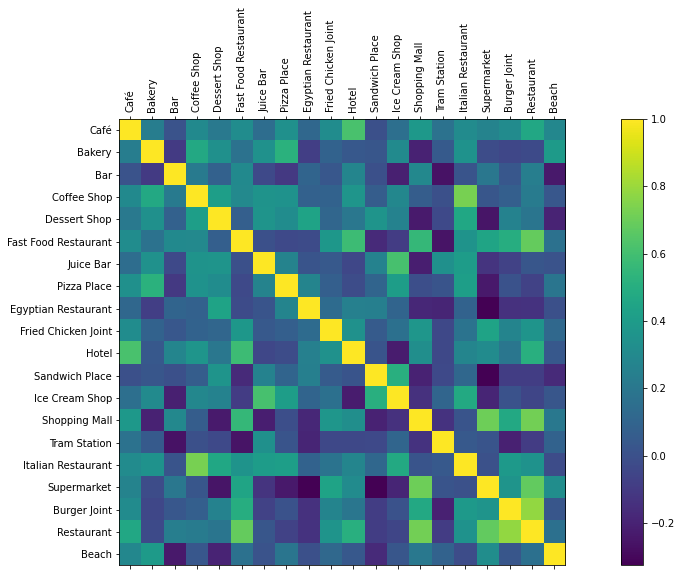

In [205]:
corr_mat = ven_cats_dest_df.corr()

plt.figure(figsize=(20,8))
plt.matshow(corr_mat, fignum=1)
plt.xticks(ticks=range(len(corr_mat.columns)), labels=corr_mat.columns, rotation=90)
plt.yticks(ticks=range(len(corr_mat.columns)), labels=corr_mat.columns)
plt.colorbar()
plt.show()

So let's clear the corrolation matrix, to have a better look at the corrolations

In [166]:
corr_mat[(corr_mat > 0.5) | (corr_mat < -0.5)]

,Café,Bakery,Bar,Coffee Shop,Dessert Shop,Fast Food Restaurant,Juice Bar,Pizza Place,Egyptian Restaurant,Fried Chicken Joint,Hotel,Sandwich Place,Ice Cream Shop,Shopping Mall,Tram Station,Italian Restaurant,Supermarket,Burger Joint,Restaurant,Beach
Café,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bakery,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.518853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bar,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coffee Shop,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.730332,NaN,NaN,NaN,NaN
Dessert Shop,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fast Food Restaurant,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.584279,NaN,NaN,0.557172,NaN,NaN,NaN,0.500196,0.688638,NaN
Juice Bar,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.615632,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pizza Place,NaN,0.518853,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Egyptian Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fried Chicken Joint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see many categories that are corrolated, like:
- Pizza Place and a Bakery (0.52)
- Hotel and a Cafe (0.62)
- Italian resturant and a Coffe shop (0.73)
- Juice bar and an Ice cream shop (0.62)
- And at the bottom-right we can see multiple high corrolations, that is because all of these venue categories **[Restaurant, Burger Joint, Fast Food Restaurant]**, usually exsists in shopping malls, or around them, due to high people turn out.</br></br>
 **Note:** We can eliminate the shopping mall related categories, due to high cost, and the client may be limited to a lower cost project.

Let's then focus on the categories [Pizza Place, Bakery, Hotel, Cafe, Italian resturant, Coffe Shop, Juice Bar, Ice Cream Shop]

In [0]:
focus_cats_group_1 = ["Pizza Place", "Bakery"]
focus_cats_group_2 = ["Hotel", "Café"]
focus_cats_group_3 = ["Italian Restaurant", "Coffee Shop"]
focus_cats_group_4 = ["Juice Bar", "Ice Cream Shop"]

# Set the defult size of figures
plt.rcParams['figure.figsize'] = (15, 6)

**Option one: Pizza place and a Bakery**
--

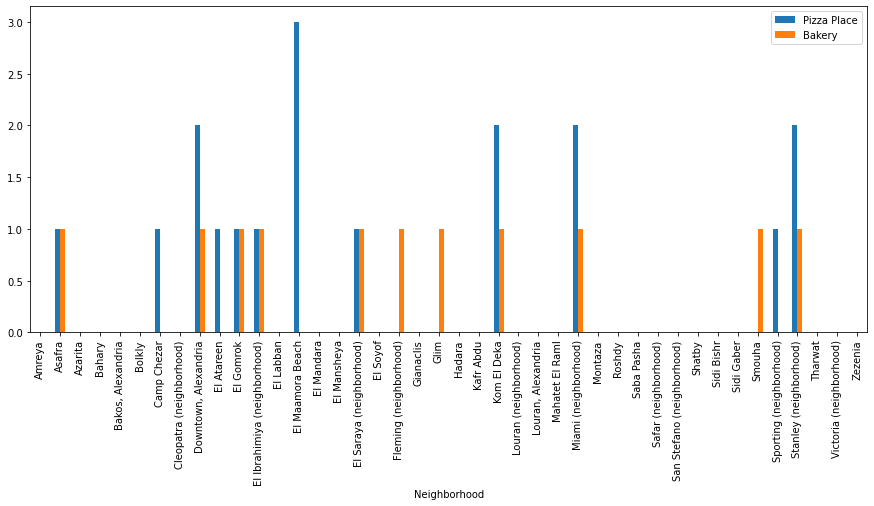

In [217]:
# Foucs group one
ven_cats_dest_df[focus_cats_group_1].plot(kind='bar')
plt.show()

As we can see there is some corrolation that pizza place relay on the products of a bakery to serve all sorts of pizza types, and for each two pizza places, there usually one bakery shop. And **El Maamora Beach** has three pizza places, with no bakery.</br>
*Conclusion:* </br>The probability of a successful bakery project in El Maamora Beach neighborhood is ***High***.

**Option two: Cafe and a Hotel**
----

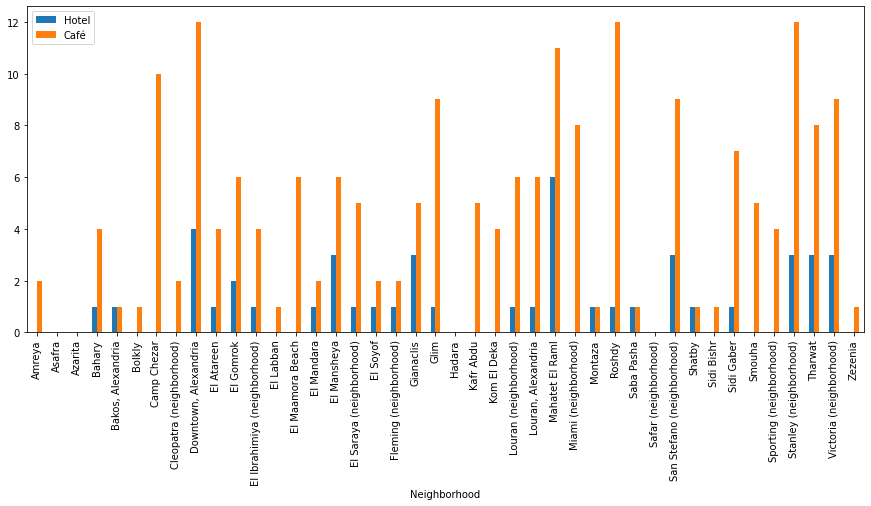

In [218]:
# Foucs group two
ven_cats_dest_df[focus_cats_group_2].plot(kind='bar')
plt.show()

While having some outliers like *Camp Chezar* neighborhood - that have no hotels but high number of cafes, that is because it is a campus area of Alexandria University so there are alot of students going there -, except there is a general trend that with higher number of hotels, there is a higher number of cafes.</br>
*Conclusion:*</br>
Due to the overwhelming number of cafes in Alexandria is is **NOT** recommended to open a cafe.

**Option three: Italian restaurant and a coffee shop**
---

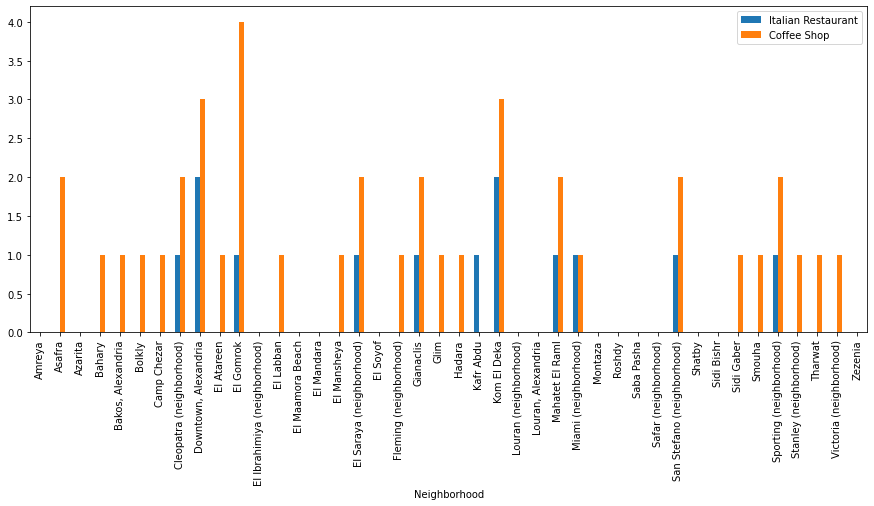

In [219]:
# Foucs group Three
ven_cats_dest_df[focus_cats_group_3].plot(kind='bar')
plt.show()

Going deeper and unvaling the insights of the numbers of italian resturants and the coffee shops, there is no clear relation between the two.</br>
*Concolusion:*</br>
There is **no clear indication** on the success of failure of opening an italian resturants or a coffee shop.

**Option four: Juice bar and an Ice cream shop**
---

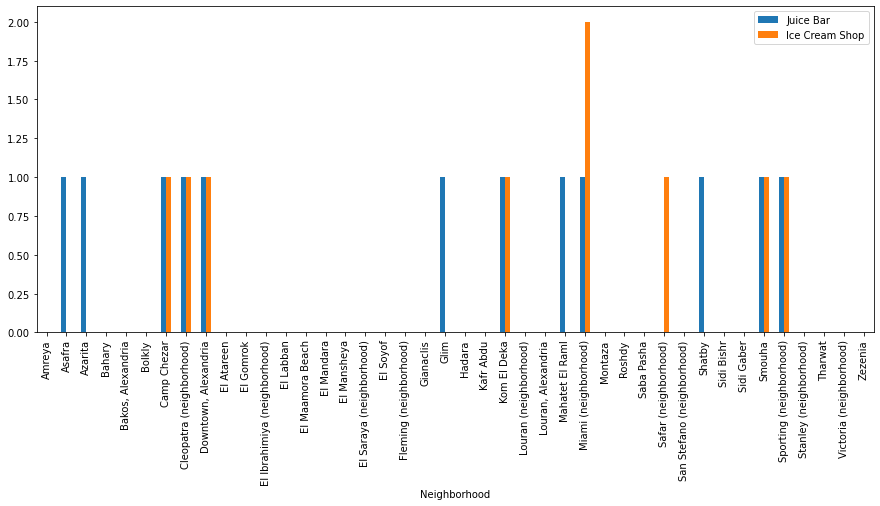

In [220]:
# Foucs group Three
ven_cats_dest_df[focus_cats_group_4].plot(kind='bar')
plt.show()

In this option, opening an ice cream shop, or a juice bar appears to be new, or at least not popular yet, because their exist a number of both all around Alexandria, so opening an ice cream shop, or a juice bar in one of the neighborhoods that don't have one might be an advantage.</br>
*Concolusion:*</br>
The probability of opening a successful ice cream shop, or a juice bat in a neighborhood that don't have either one of them is **Medium**.

Conclusion
===
In this project we walked-through the idea of using corrolation between existing different categories of businesses to identify the possibility of a successful business.</br>
And we figured out that there are four possible options to investigate:
- Pizza Place and a Bakery
- Hotel and a Cafe
- Italian resturant and a Coffe shop
- Juice bar and an Ice cream shop</br>
And after investigation, we found that **opening a bakery shop in El Maamora Beach neighborhood** is the best option, if we applied the idea of using the corrolation between businesses.